# Hourly Time Series Forecasting using XGBoost

[If you haven't already first check out my previous notebook forecasting on the same data using Prophet](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-prophet)

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

In [1]:
import os
# set working directory to root 
os.chdir('/home/qiangzibro/2021-math-model-code')
os.getcwd()

'/home/qiangzibro/2021-math-model-code'

In [2]:
import pandas as pd, numpy as np
from common.io import load, load_tables, PLACES
from common.utils import find_pollution_columns, POLLUTIONS, write_excel
from sklearn.preprocessing import OneHotEncoder
from prob1.aqi import compute_aqi
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# Linux上解决字体问题
plt.rcParams['font.sans-serif']= ['Noto Serif CJK JP'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False 

FORMAT = 'pdf'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data

In [4]:
data = load_tables(['A']+[f'A{i}' for i in range(1,4)])

11.18564510345459s passed


# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [5]:
POLLUTIONS1 = ['SO2监测浓度(μg/m³)',
       'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)',
       'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)']

# Create Time Series Features

In [6]:
def preprocess_pollution_columns(df):
    pol_cols = find_pollution_columns(df)
    for name, col_name in zip(POLLUTIONS, pol_cols):
        df[name] = df[col_name]
    return df

# preprocess_pollution_columns(data['A1']['1'])

In [7]:
import warnings 
warnings.filterwarnings("ignore")
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    
    df['date'] = df.监测时间 if '监测时间' in df.keys() else df.监测日期
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    _ = POLLUTIONS.copy()
    _.remove(label)
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'] +
            _
          ]
    if label:
        y = df[label]
        return X, y
    return X

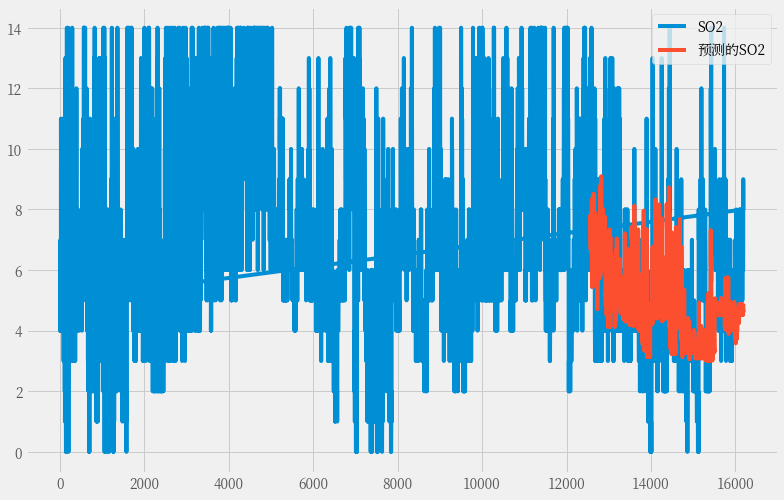

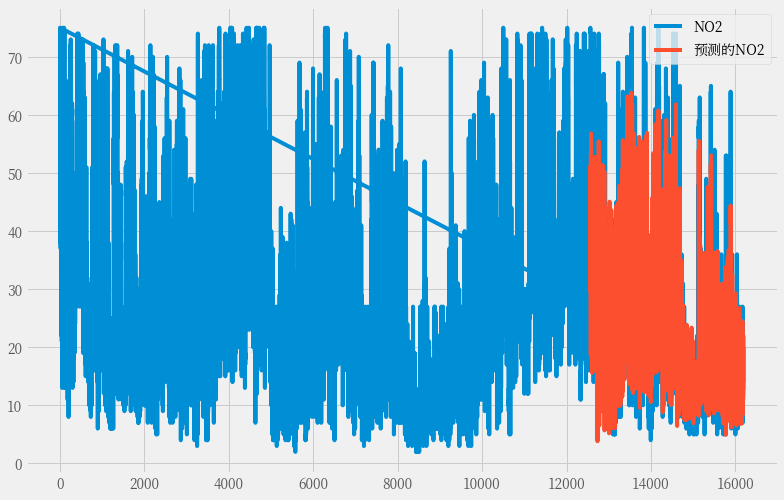

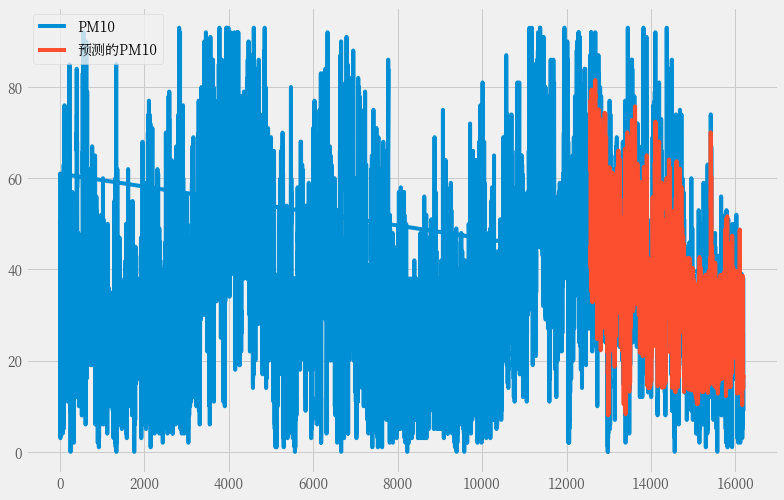

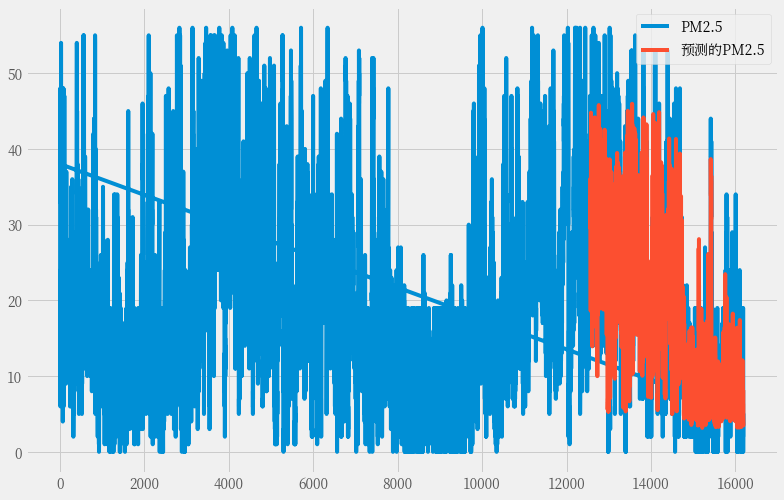

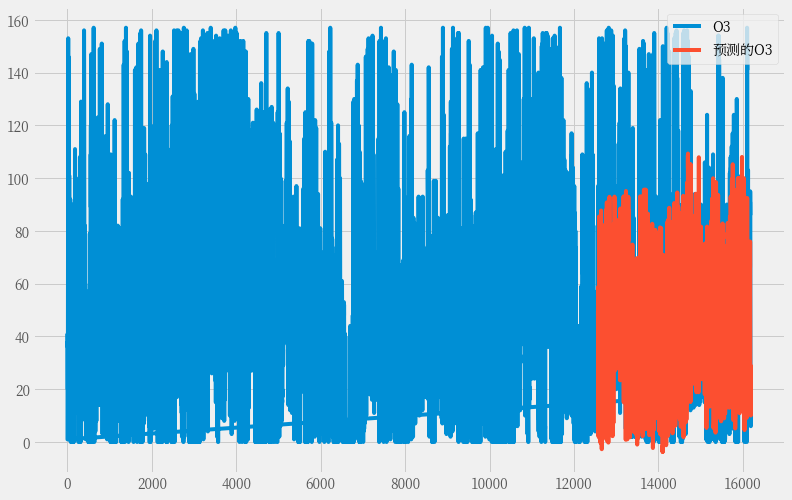

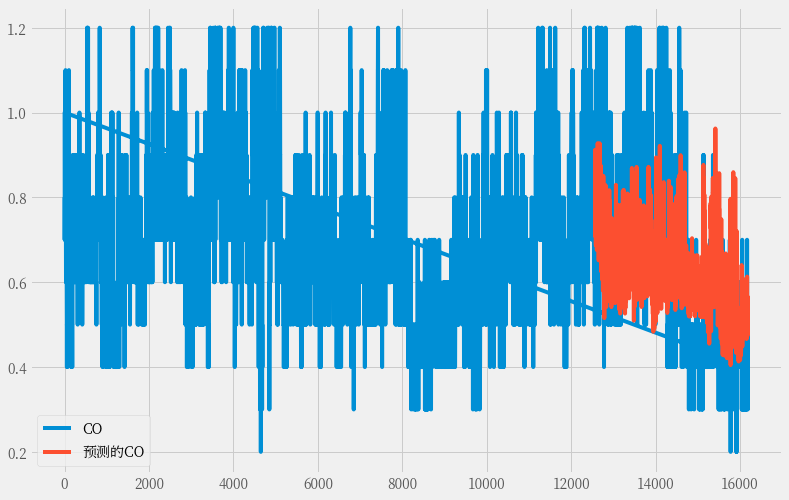

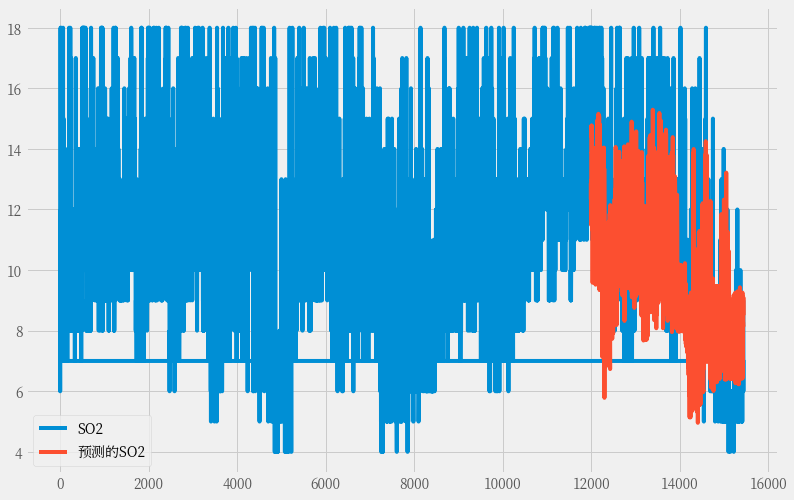

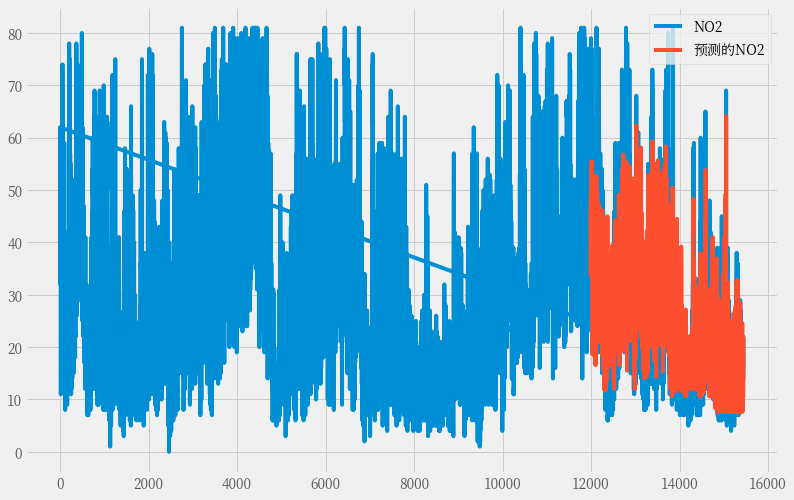

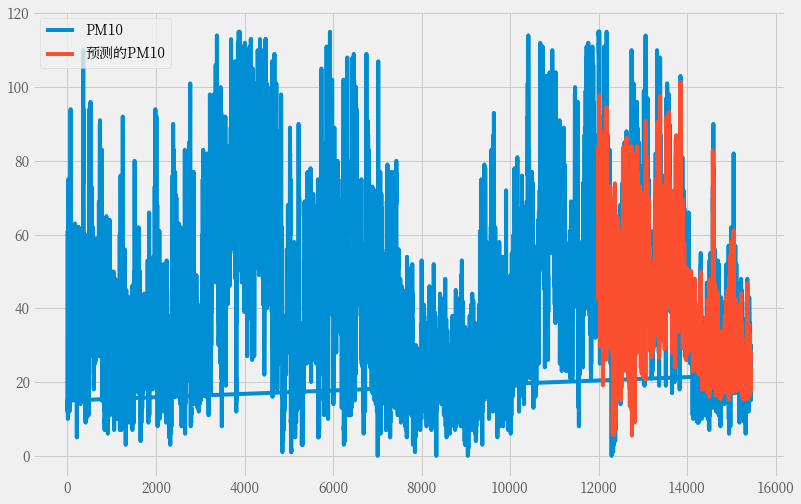

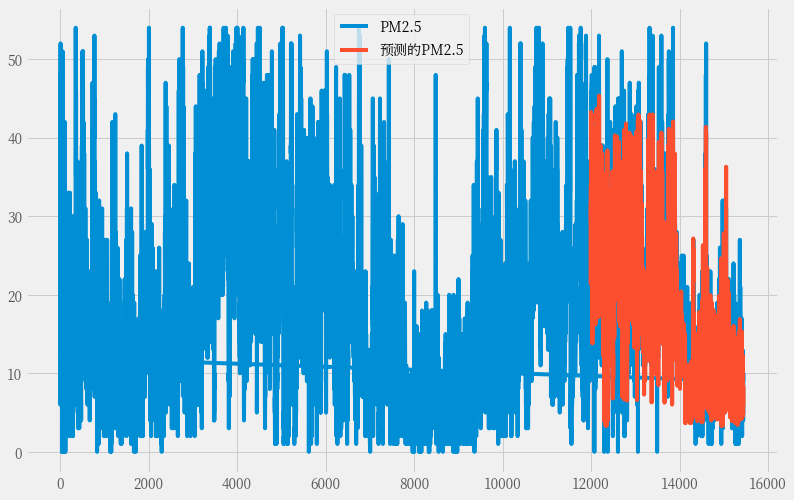

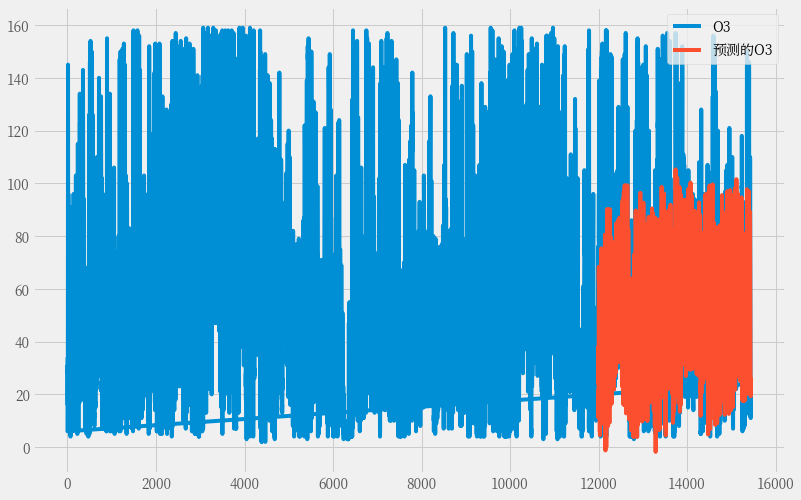

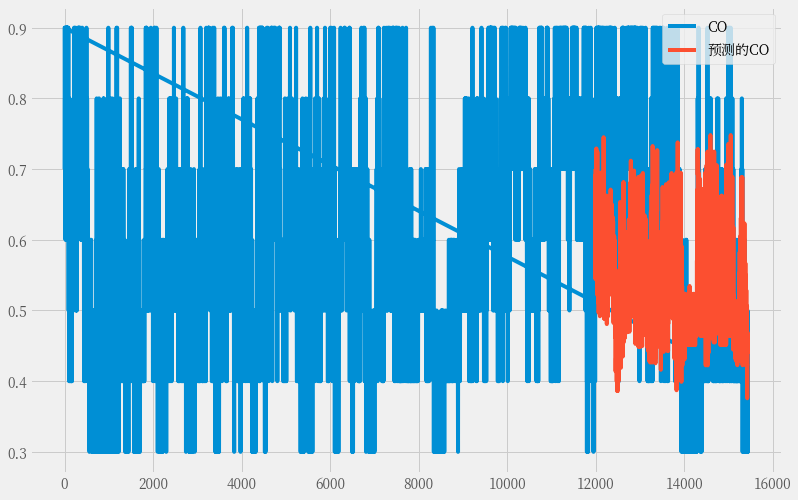

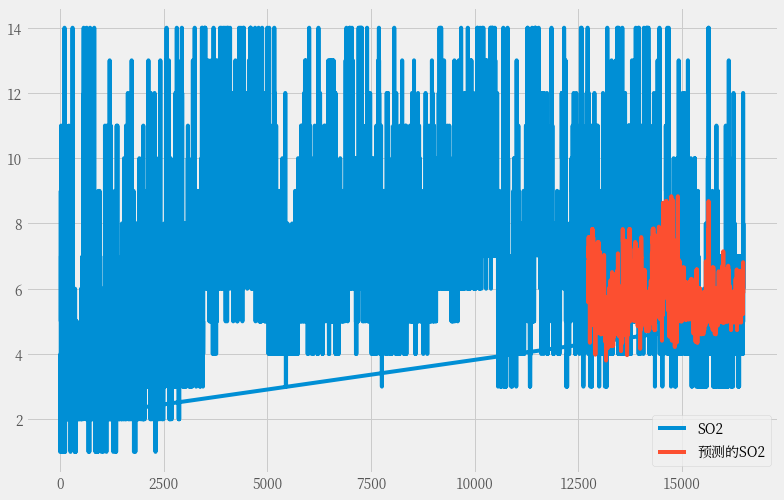

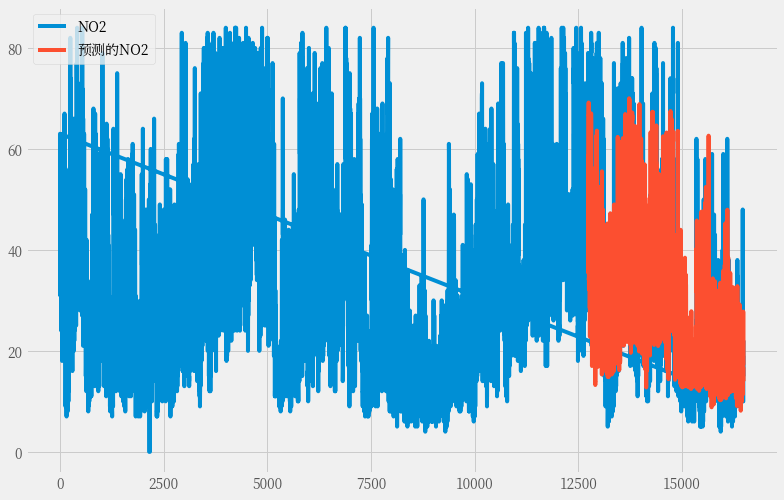

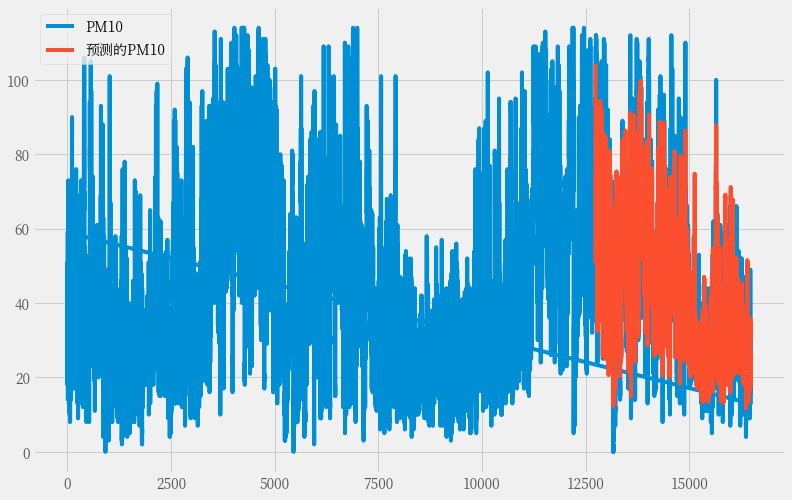

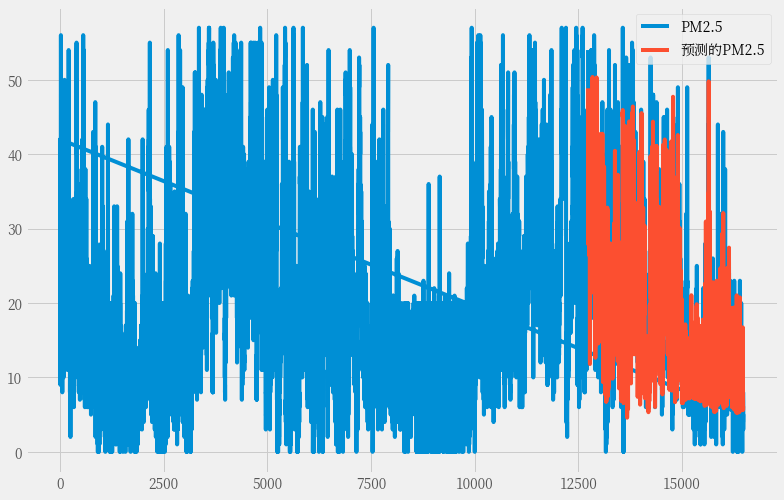

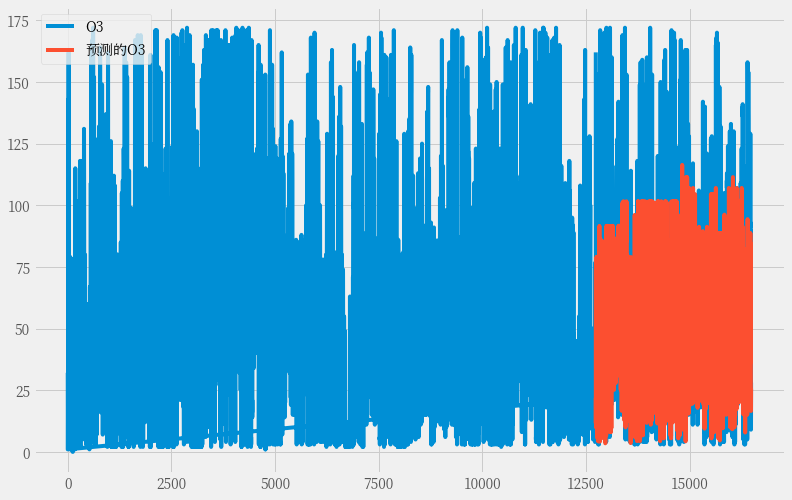

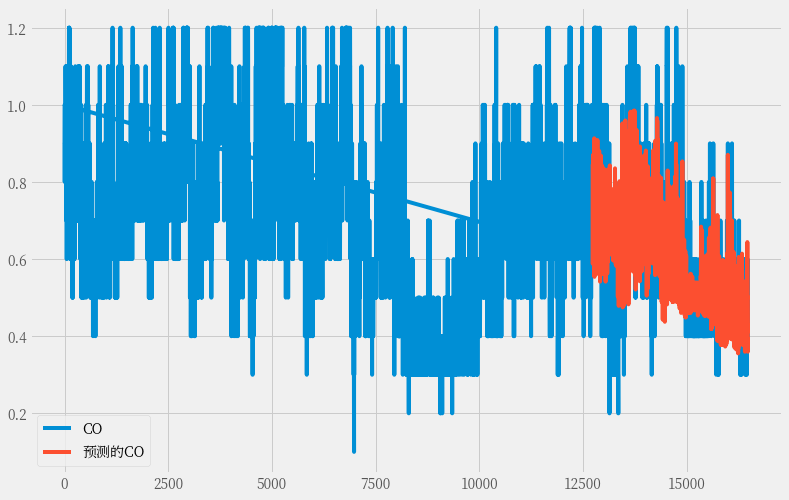

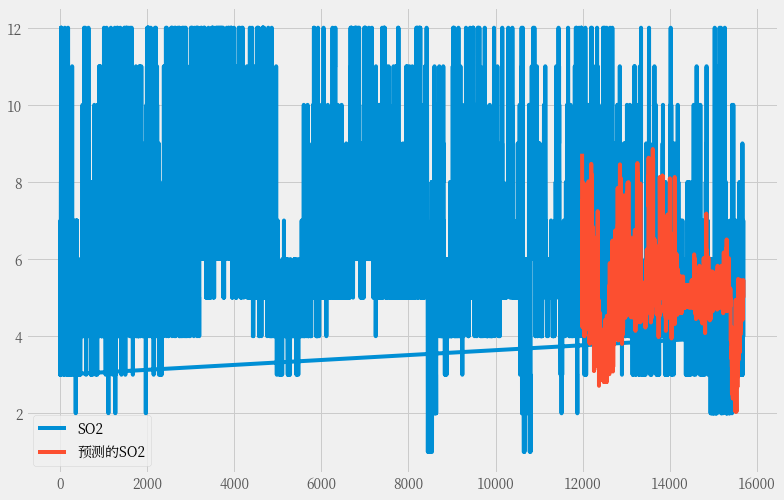

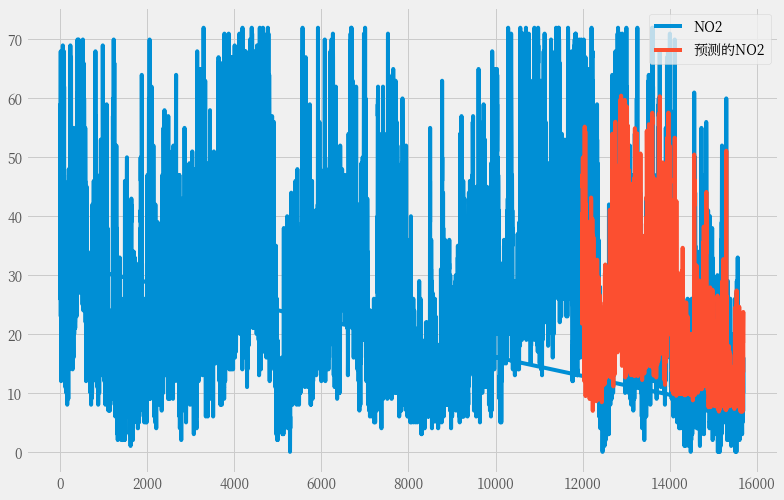

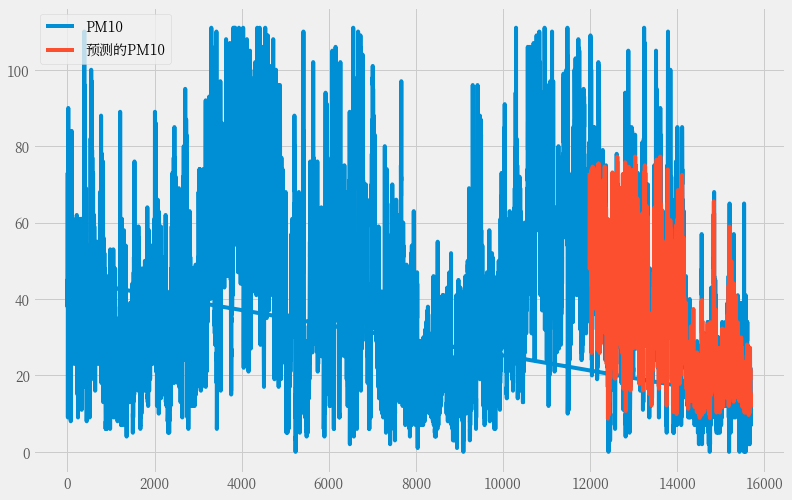

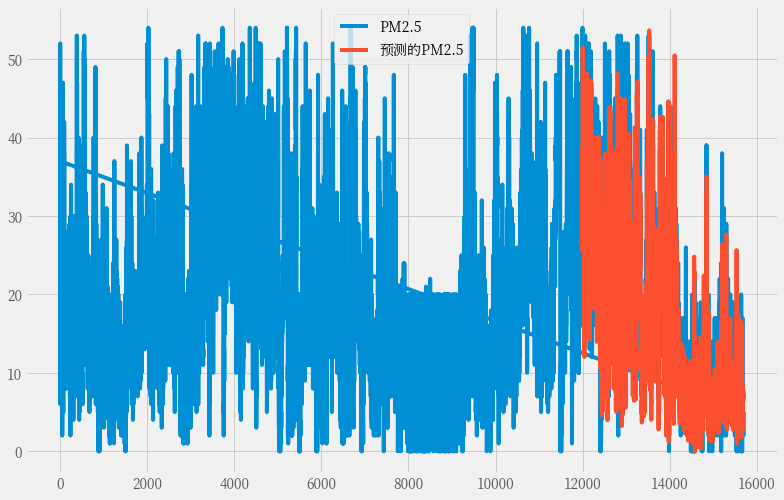

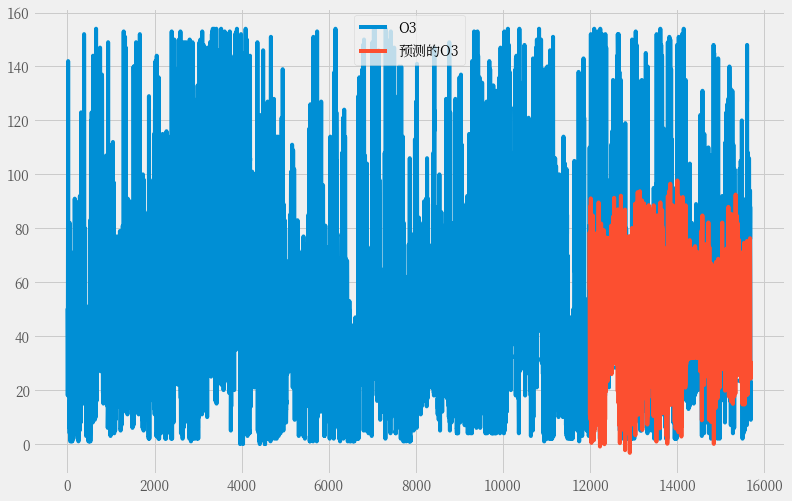

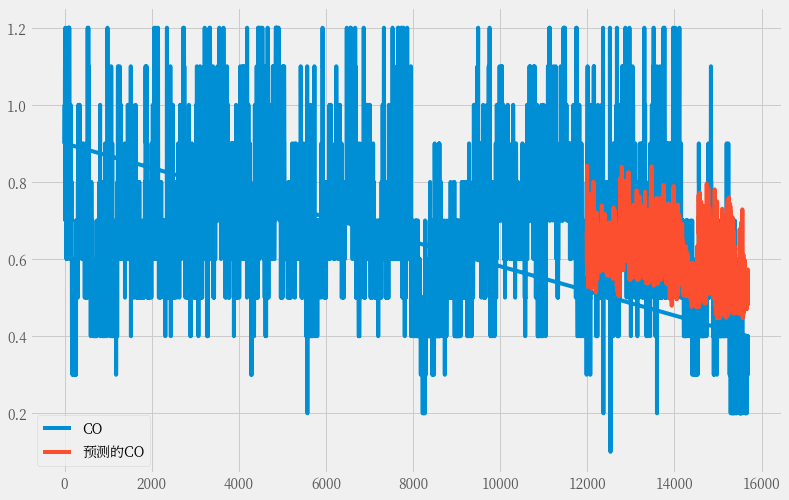

In [8]:
def train():
    result={}
    for place in ['A']+[f'A{i}' for i in range(1,4)]:
        df = data[place]['1']
        preprocess_pollution_columns(df)
        split_date = '2021-01-13'
        train_data = df.loc[df.监测时间 <= split_date].copy()
        test_data = df.loc[df.监测时间 > split_date].copy()


        regs = {}
        for p in POLLUTIONS:
            X_train, y_train = create_features(train_data, label=p)
            X_test, y_test = create_features(test_data, label=p)
            reg = xgb.XGBRegressor(n_estimators=1000)

            reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=5000,
               verbose=False) # Change verbose to True if you want to see it train

            test_data["预测的"+p] = reg.predict(X_test)
            all_data = pd.concat([test_data, train_data], sort=False)

            _ = all_data[[p,"预测的"+p]].plot(figsize=(12, 8))
            plt.savefig(f"results/prob4/预测{place}地_{p[:4]}."+FORMAT, format=FORMAT)
            # plt.close()
            regs[p] = reg
        result[place] = regs
    return result

result = train()

In [9]:
def test(result):
    writer = pd.ExcelWriter("results/prob4/result.xlsx", engine='xlsxwriter')
    for place in ['A']+[f'A{i}' for i in range(1,4)]:
        data_dict = {}
        df = data[place]['2']
        df = preprocess_pollution_columns(df)
        split_date = '2021-07-13'
        test_data = df.loc[df.监测日期 >= split_date].copy()
        for p in POLLUTIONS:
            X_test, y_test = create_features(test_data, label=p)
            reg = result[place][p]
            test_data["预测的"+p] = reg.predict(X_test)
            data_dict[p] = list(test_data["预测的"+p])
            
        frame = pd.DataFrame(data=data_dict)
        
        aqis = []
        main_factors = []
        for i in range(len(frame)):
            polu = list(frame.iloc[i])
            polu[-2] *= 4/3 * polu[-2] #考虑二次污染
            aqi, main_factor = compute_aqi(*polu, True)
            aqis.append(aqi)
            main_factors.append(main_factor)
        frame['AQI'] = aqis
        frame['主要污染物'] = main_factors
        
        frame.to_excel(writer, sheet_name=place)
        print(frame)
    writer.save()
test(result)

        SO2        NO2       PM10      PM2.5        O3        CO  AQI 主要污染物
0  4.598626  19.221251  37.218903  19.357082  18.66456  0.633464  237    O3
1  4.598626  19.221251  37.218903  19.357082  18.66456  0.651563  237    O3
2  4.598626  17.575596  37.218903  19.357082  18.66456  0.651563  237    O3
         SO2        NO2       PM10      PM2.5         O3        CO  AQI 主要污染物
0  10.206174  16.206217  46.821621  17.745615  24.873306  0.587807   47  PM10
1  10.206174  16.206217  46.821621  17.745615  24.873306  0.587807   47  PM10
2   9.470160  16.206217  46.821621  17.745615  24.873306  0.587807   47  PM10
        SO2        NO2       PM10      PM2.5         O3        CO  AQI 主要污染物
0  6.181599  23.250044  45.936111  17.961695  14.939068  0.499452  206    O3
1  6.181599  23.250044  45.936111  17.961695  14.939068  0.499452  206    O3
2  6.181599  23.250044  45.936111  17.961695  14.939068  0.479596  206    O3
       SO2        NO2       PM10      PM2.5         O3        CO  AQI 主要污染物


# Create XGBoost Model

In [10]:
_ = plot_importance(reg, height=0.9, )

NameError: name 'reg' is not defined

# Look at first month of predictions

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_data[[POLLUTIONS1[0],"预测的"+POLLUTIONS1[0]]].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='2021-06-13', upper='2021-07-13')
# ax.set_ylim(0, 60000)
# plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2021-06-13', upper='2021-07-13')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [ ]:
mean_squared_error(y_true=test_data['PJME_MW'],
                   y_pred=test_data['MW_Prediction'])

In [ ]:
mean_absolute_error(y_true=test_data['PJME_MW'],
                   y_pred=test_data['MW_Prediction'])

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=test_data['PJME_MW'],
                   y_pred=test_data['MW_Prediction'])

# Look at Worst and Best Predicted Days

In [ ]:
test_data['error'] = test_data['PJME_MW'] - test_data['MW_Prediction']
test_data['abs_error'] = test_data['error'].apply(np.abs)
error_by_day = test_data.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

# Plotting some best/worst predicted days

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.